In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
from scipy.optimize import curve_fit
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)
#print("scipy.optimize version", scipy.optimize.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
vector.register_awkward() 

In [3]:
# Fonction de récupération de certains vecteurs et "triggers" des événements.
def getTracksData(events):
    return ak.zip({
        "px"      : events["Muon_Px"],
        "py"      : events["Muon_Py"],
        "pz"      : events["Muon_Pz"],
        "E"       : events["Muon_E"],
        "charge"  : events["Muon_Charge"],
        "thetaAbs": events["Muon_thetaAbs"],
        "matched" : events["Muon_matchedTrgThreshold"]},
        with_name='Momentum4D')

# Fonction de sommation des composantes quadri-vectorielles des paires de di-muons candidats.
def Momentum4D(events):
    return ak.zip({
        "px": events["0"].px + events["1"].px,
        "py": events["0"].py + events["1"].py,
        "pz": events["0"].pz + events["1"].pz,
        "E" : events["0"].E  + events["1"].E},
        with_name="Momentum4D")

# Fonction principale d'extraction des données expérimentales.
def scan(dataDescription, 
         hMagData:hist.Hist, hPhiData:hist.Hist, hEtaData:hist.Hist, hYData:hist.Hist, hPtData:hist.Hist, hMassData:hist.Hist, hMass_OSData:hist.Hist, hMass_LSData:hist.Hist,
         eventSelectorData = lambda x:[True]*len(x),
         trackSelectorData = lambda x:[True]*len(x),
         pairSelectorData = lambda x:[True]*len(x),
         verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    # Initialisation de plusieurs compteurs pour observer le nombre d'événements "nGoodEntries", de traces "nGoodTracks" et de paires "nGoodOS-LS" conservés par "run" de données.
    nEntries = nGoodEvents = nGoodTracks = nGoodEntries = nPairs = nOS = nGoodOS = nLS = nGoodLS = 0
    
    # Boucle d'itération sur le nombre d'événements. Chaque batch contient le nombre d'événement ainsi que ses caractéristiques.
    for batch in uproot.iterate(dataDescription,
                                ["isCINT", "isCMUL", "isCMSL", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge", "Muon_thetaAbs", "Muon_matchedTrgThreshold"],                                
                                report = True):
        
        # Récupération et test sur les événéements pour éviter les données corrompues.
        events = batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
        
        # Selections sur les événements et les traces.
        goodEvents = events[eventSelectorData(events)]
        tracks = getTracksData(goodEvents)
        goodTracks = tracks[trackSelectorData(tracks)]
        
        # Formation de toutes les combinaisons de paires possibles par événements.
        pairs = ak.combinations(goodTracks, 2)
        
        # Condition et selection sur les paires de muons candidats de signe opposé (OS: Opposite-Sign) 
        condition_OS = np.logical_or(np.logical_and(pairs["0"].charge ==  1, pairs["1"].charge == -1),
                                     np.logical_and(pairs["0"].charge == -1, pairs["1"].charge ==  1))
        pairs_OS = pairs[condition_OS]
        OS = Momentum4D(pairs_OS)
        goodOS = OS[pairSelectorData(OS)]
        
        # Condition et selection sur les paires de muons candidats de même signe (LS: Like-Sign)
        condition_LS = np.logical_or(np.logical_and(pairs["0"].charge == -1, pairs["1"].charge == -1),
                                     np.logical_and(pairs["0"].charge ==  1, pairs["1"].charge ==  1))
        pairs_LS = pairs[condition_LS]
        LS = Momentum4D(pairs_LS)
        goodLS = LS[pairSelectorData(LS)]
        
        
        # Remplissage des histogrammes
        hMagData.fill(ak.flatten(goodTracks.p))  
        hPtData.fill(ak.flatten(goodTracks.pt))
        hPhiData.fill(ak.flatten(goodTracks.phi))
        hEtaData.fill(ak.flatten(goodTracks.eta))
        hMassData.fill(ak.flatten(goodTracks.mass))
        hYData.fill(ak.flatten(goodOS.rapidity))
        hMass_OSData.fill(ak.flatten(goodOS.mass))
        hMass_LSData.fill(ak.flatten(goodLS.mass))
        

        # Actualisation des compteurs par "batch" de données.
        nEntries += len(events)
        nGoodEvents += len(goodEvents)
        nGoodTracks += len(ak.flatten(goodTracks))
        nGoodEntries += list(ak.num(goodTracks) > 0).count(True)
        nPairs += len(ak.flatten(pairs))
        nOS += len(ak.flatten(OS))
        nGoodOS += len(ak.flatten(goodOS))
        nLS += len(ak.flatten(LS))
        nGoodLS += len(ak.flatten(goodLS))

        # Affichage du "run" extrait et des compteurs associés.
        if verbose:
            print(batch[1])
            print("Entries: ", nEntries)
            print("Good Events: ", nGoodEvents)
            print("Good Tracks: ", nGoodTracks)
            print("Good Entries: ", nGoodEntries)
            print("Pairs: ", nPairs)
            print("OS: ", nOS)
            print("Good OS:", nGoodOS)
            print("LS: ", nLS)
            print("Good LS:", nGoodLS)
            print("---------------------------------------------------------------------------------------")
        gc.collect()
        
    # Renvoie les compteurs pour un affichage final.
    return nEntries, nGoodEvents, nGoodTracks, nGoodEntries, nPairs, nOS, nGoodOS, nLS, nGoodLS

In [4]:
# Numéros des "runs" gardés en commun avec tous les groupes de recherches.
SAMPLE_RUNS = sorted([290323, 290327, 290848, 291361, 291360, 291362, 290853, 290860, 291373, 290374, 290375, 291399,
               291400, 290894, 290895, 290404, 291943, 291944, 291948, 291953, 290932, 290423, 291447, 290935, 
               290425, 290427, 291451, 291453, 291976, 291982, 290456, 290458, 290459, 291482, 291485, 290975, 
               290980, 290469, 292012, 291002, 291003, 291004, 291005, 290501, 292040, 292060, 292061, 292062, 
               291041, 290539, 290540, 292075, 292077, 292080, 290549, 290553, 291590, 292106, 292108, 292109, 
               292115, 290590, 291618, 291622, 291624, 292140, 290612, 292160, 292162, 292163, 292164, 292166, 
               290632, 291657, 292168, 292192, 290658, 290660, 291690, 291692, 291694, 291698, 291706, 290687, 
               290692, 290696, 290699, 292242, 292265, 291755, 292269, 292270, 291760, 292273, 292274, 290742, 
               291769, 291263, 290764, 290766, 291283, 291284, 291285, 291795, 291796, 290776, 291803, 290787])
print(len(SAMPLE_RUNS))

108


In [16]:
%%time

# Création des différents histogrammes pour visualiser les résultats issus des données expérimentales.
hMag= hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhi = hist.Hist(hist.axis.Regular(bins = 200, start = -np.pi, stop = np.pi, name = '$\phi$'))
hEta = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hPt = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMass = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))

hY_OS = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hMass_OS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

# Initialisation des compteurs pour avoir un rendu final sur tous les "runs".
Entries = goodEvents = goodTracks = goodEntries = Pairs = goodPairs = OS = goodOS = LS = goodLS = 0

# Appel de la fonction "scan" pour l'extraction des données pour tous les "runs".
for run in SAMPLE_RUNS:
    a, b, c, d, e, f, g, h, i = scan(dataDescription = f"/pbs/throng/training/nantes-m2-rps-exp/data/run{run}.data.root:eventsTree",
                                      hMagData = hMag, hPhiData = hPhi, hEtaData = hEta, hYData = hY_OS, hPtData = hPt, hMassData = hMass, hMass_OSData = hMass_OS, hMass_LSData = hMass_LS,
                                      eventSelectorData = lambda x: x["isCMUL"] == True, 
                                      trackSelectorData = lambda x: (x.thetaAbs < 10) & (x.thetaAbs > 2) & (x.pt > 0.5) & (x.eta > -4.0) & (x.eta < -2.5),# & (x.matched == 2),
                                      pairSelectorData = lambda x: (x.rapidity > -2.8) & (x.rapidity < -2.5),# & (x.pt > 6) & (x.pt < 8),
                                      verbose = True)
    
    # Actualisation des compteurs.
    Entries += a
    goodEvents += b
    goodTracks += c
    goodEntries += d
    Pairs += e
    OS += f
    goodOS += g
    LS += h
    goodLS += i

# Affichage final sur le comptage total des événements, traces et paires gardés.
print("Entries: ", Entries)
print("Good Events: ", goodEvents)
print("Good Tracks: ", goodTracks)
print("Good Entries: ", goodEntries)
print("Pairs: ", Pairs)
print("OS: ", OS)
print("Good OS: ", goodOS)
print("LS: ", LS)
print("Good LS: ", goodLS)

<Report start=0 stop=2139140 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.data.root:/eventsTree;1'>
Entries:  2139140
Good Events:  410205
Good Tracks:  288978
Good Entries:  231741
Pairs:  60444
OS:  51629
Good OS: 4040
LS:  8815
Good LS: 973
---------------------------------------------------------------------------------------
<Report start=0 stop=190395 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290327.data.root:/eventsTree;1'>
Entries:  190395
Good Events:  36880
Good Tracks:  25729
Good Entries:  20668
Pairs:  5362
OS:  4592
Good OS: 363
LS:  770
Good LS: 89
---------------------------------------------------------------------------------------
<Report start=0 stop=1109829 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290374.data.root:/eventsTree;1'>
Entries:  1109829
Good Events:  213125
Good Tracks:  150005
Good Entries:  120273
Pairs:  31325
OS:  26787
Good OS: 2098
LS:  4538
Good LS: 540
---------------------------------------------------

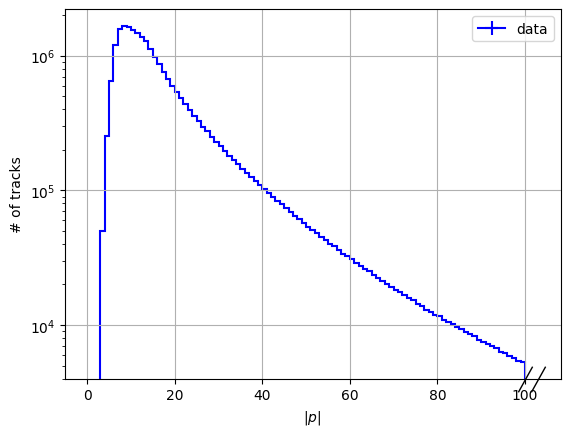

In [17]:
hMag.plot(color = "blue", label = "data")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

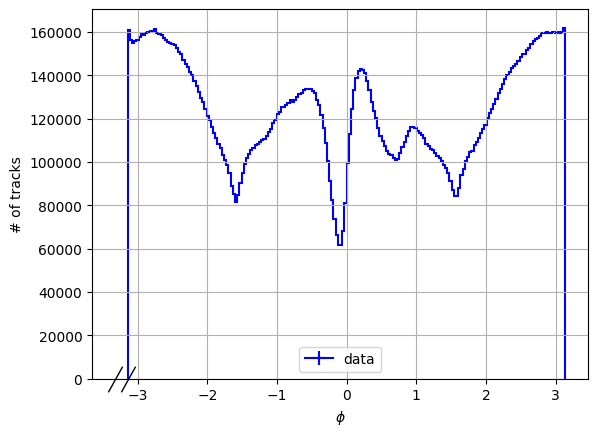

In [18]:
hPhi.plot(color = "blue", label = "data")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

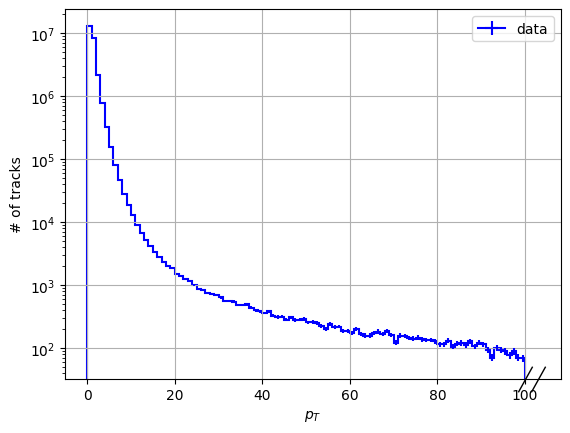

In [19]:
hPt.plot(color = "blue", label = "data")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

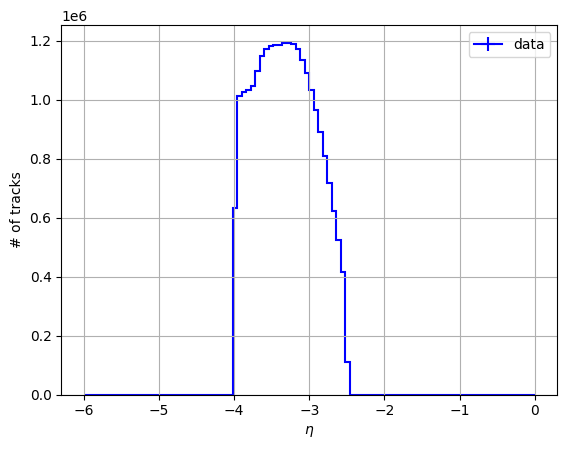

In [20]:
hEta.plot(color = "blue", label = "data")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

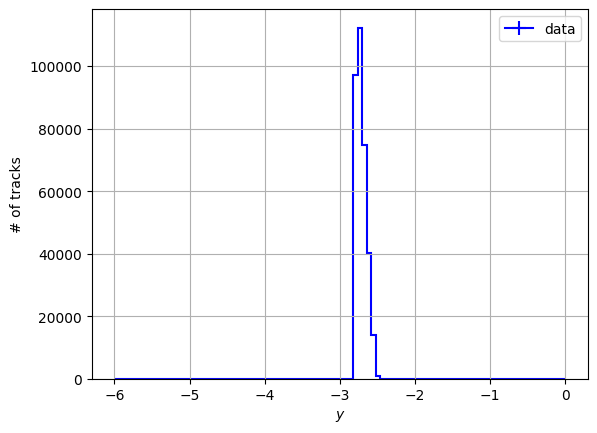

In [21]:
hY_OS.plot(color = "blue", label = "data")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

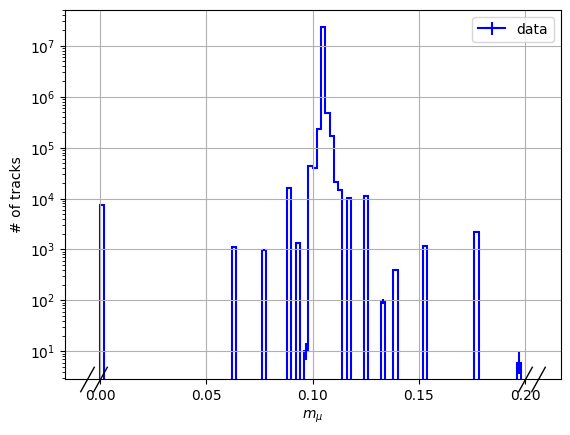

In [22]:
hMass.plot(color = "blue", label = "data")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

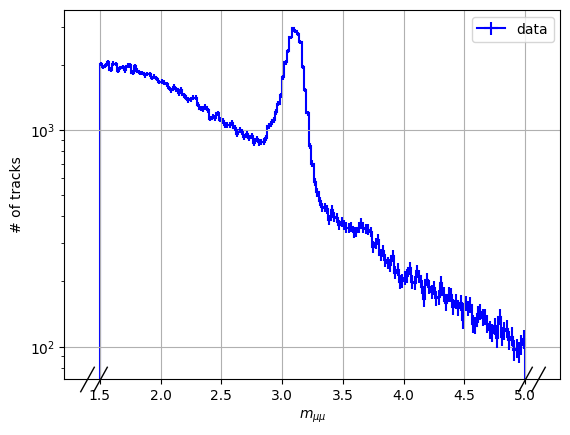

In [23]:
hMass_OS.plot(color = "blue", label = "data")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

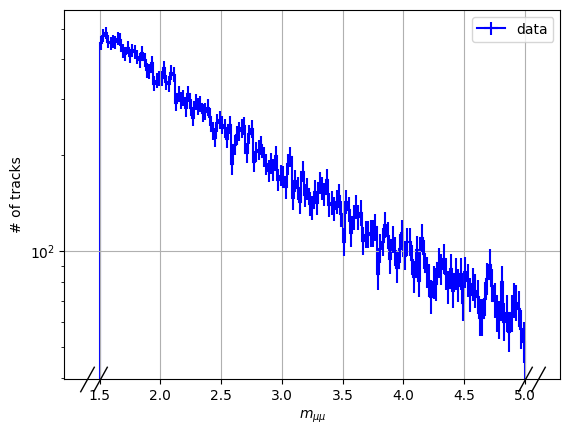

In [24]:
hMass_LS.plot(color = "blue", label = "data")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

In [25]:
print(hMass_OS.axes[0].centers.tolist())
print(hMass_OS.view().tolist())
print(hMass_LS.view().tolist())

[1.5099999999999998, 1.53, 1.55, 1.57, 1.59, 1.6099999999999999, 1.6300000000000001, 1.65, 1.67, 1.69, 1.71, 1.73, 1.75, 1.77, 1.79, 1.81, 1.83, 1.85, 1.87, 1.89, 1.9100000000000001, 1.93, 1.95, 1.97, 1.9900000000000002, 2.0100000000000002, 2.03, 2.05, 2.0700000000000003, 2.09, 2.1100000000000003, 2.13, 2.1500000000000004, 2.17, 2.19, 2.21, 2.23, 2.25, 2.27, 2.29, 2.3099999999999996, 2.33, 2.3499999999999996, 2.37, 2.39, 2.41, 2.43, 2.45, 2.4699999999999998, 2.49, 2.5100000000000002, 2.5300000000000002, 2.55, 2.57, 2.59, 2.61, 2.63, 2.65, 2.67, 2.69, 2.71, 2.73, 2.75, 2.7700000000000005, 2.79, 2.81, 2.83, 2.85, 2.87, 2.89, 2.91, 2.9299999999999997, 2.95, 2.97, 2.99, 3.01, 3.0300000000000002, 3.0500000000000003, 3.07, 3.09, 3.1100000000000003, 3.13, 3.1500000000000004, 3.17, 3.1900000000000004, 3.21, 3.2300000000000004, 3.25, 3.27, 3.29, 3.3099999999999996, 3.3300000000000005, 3.3499999999999996, 3.37, 3.39, 3.41, 3.43, 3.4499999999999997, 3.4699999999999998, 3.49, 3.51, 3.5300000000000

In [26]:
print(dir(vector.backends.awkward.MomentumArray4D))

['E', 'E2', 'Et', 'Et2', 'GenericClass', 'M', 'M2', 'Mask', 'Mt', 'Mt2', 'ProjectionClass2D', 'ProjectionClass3D', 'ProjectionClass4D', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array__', '__array_function__', '__array_ufunc__', '__arrow_array__', '__bool__', '__bytes__', '__cast_cpp__', '__class__', '__class_getitem__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__'